### Загружаем библиотеки

In [1]:
import pandas as pd
#import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import catboost as cb
from catboost.utils import get_gpu_device_count
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

### Скачиваем данные, препроцессим даты. Заранее я перевел все в паркет для скорости.

In [2]:
train = pd.read_parquet("./data/train.parquet")
test = pd.read_parquet("./data/test.parquet")
webstat = pd.read_parquet("./data/webstat.parquet").sort_values(by='date_time')

In [3]:
train['create_time'] = pd.to_datetime(train['create_time'])
train['model_create_time'] = pd.to_datetime(train['model_create_time'])
test['create_time'] = pd.to_datetime(test['create_time'])
test['model_create_time'] = pd.to_datetime(test['model_create_time'])
webstat['date_time'] = pd.to_datetime(webstat['date_time'])
# train = train.with_columns(pl.col("create_time").str.to_datetime(), pl.col("model_create_time").str.to_datetime())
# webstat = webstat.with_columns(pl.col("date_time").str.to_datetime())

In [4]:
train.head()

,order_id,create_time,good_id,price,utm_medium,utm_source,sessionkey_id,category_id,parent_id,root_id,model_id,is_moderated,rating_value,rating_count,description_length,goods_qty,pics_qty,model_create_time,is_callcenter
0,1269921,1975-12-26 09:30:08,9896348,753,5,8.0,123777004,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,1
1,1270034,1975-12-26 10:28:57,9896348,753,1,2.0,123781654,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,0
2,1268272,1975-12-25 11:24:28,9896348,753,2,3.0,123591002,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,1
3,1270544,1975-12-26 14:16:06,9896348,753,1,1.0,123832302,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,1
4,1270970,1975-12-26 18:21:47,9896348,753,3,56.0,123881603,139,133,124,123517,1,5.0,6.0,1204,6,2,1971-04-14 00:15:20,0


### Посмотрел на данные из заказов, сгенерировал фичи на их основе.

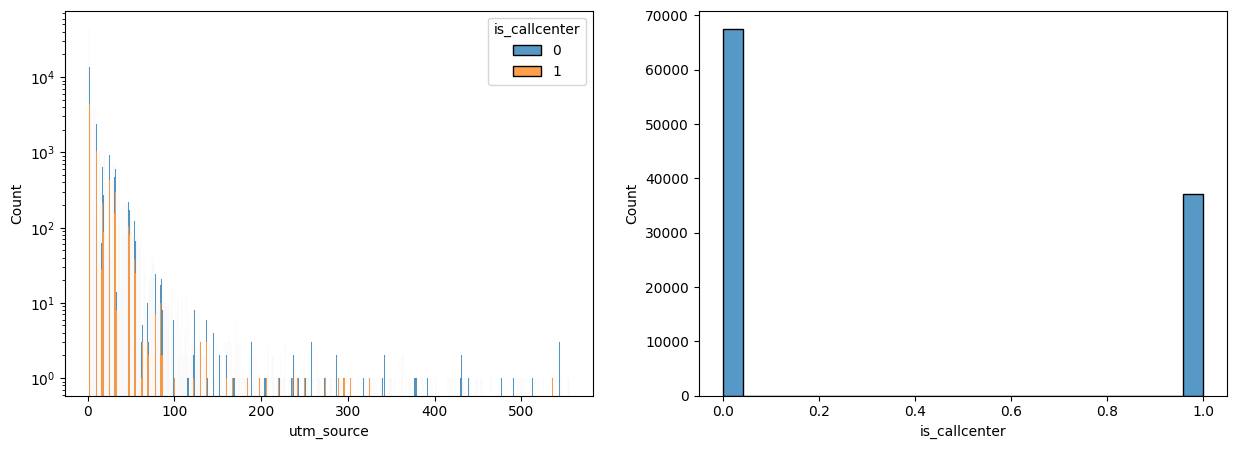

In [219]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
hist1 = sns.histplot(ax=axes[0], data=train, x="utm_source", hue="is_callcenter", multiple="stack")
hist1.set_yscale('log')
hist2 = sns.histplot(train['is_callcenter'], ax=axes[1])
plt.show()

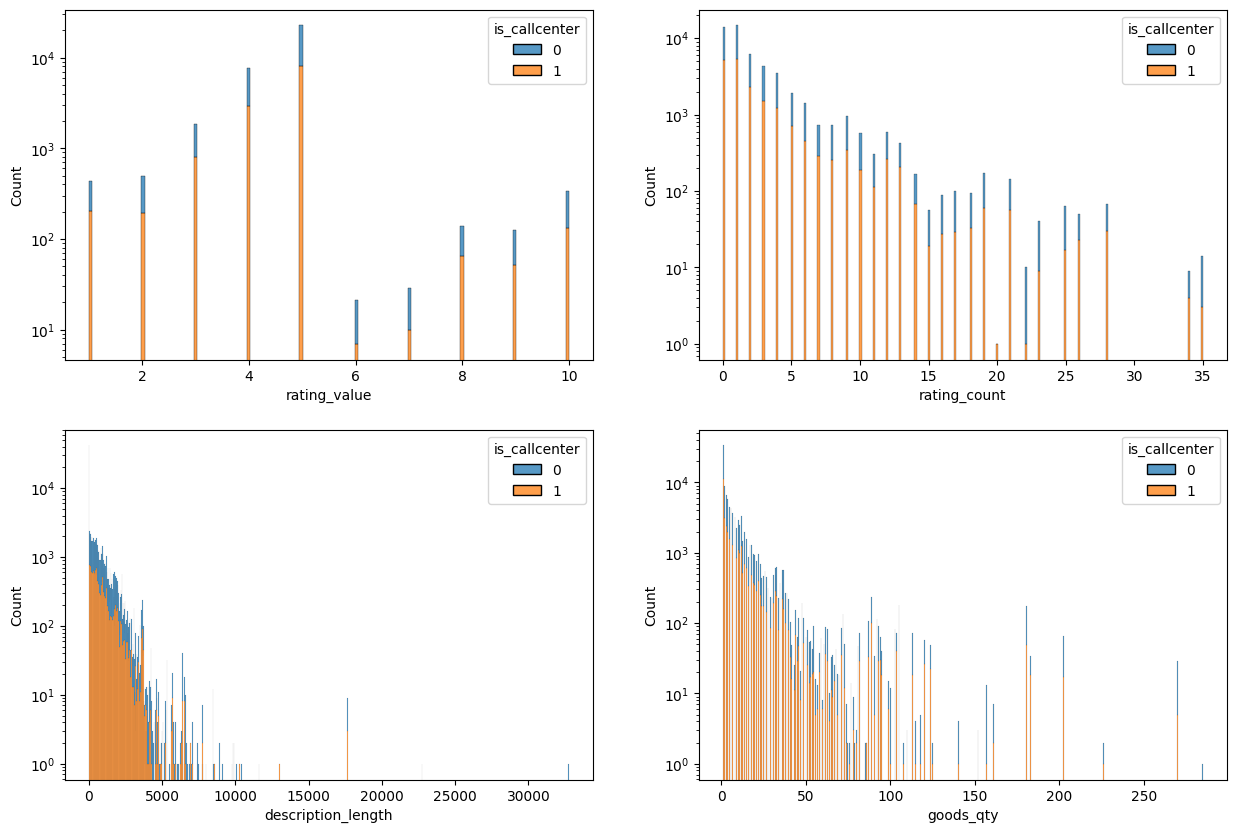

In [220]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
hist1 = sns.histplot(ax=axes[0][0], data=train, x="rating_value", hue="is_callcenter", multiple="stack")
hist1.set_yscale('log')
hist2 = sns.histplot(ax=axes[0][1], data=train, x="rating_count", hue="is_callcenter", multiple="stack")
hist2.set_yscale('log')
hist3 = sns.histplot(ax=axes[1][0], data=train, x="description_length", hue="is_callcenter", multiple="stack")
hist3.set_yscale('log')
hist4 = sns.histplot(ax=axes[1][1], data=train, x="goods_qty", hue="is_callcenter", multiple="stack")
hist4.set_yscale('log')
plt.show()

In [5]:
train["goods_bigger"] = (train['goods_qty'] > train['pics_qty']).astype(int)
train["is_ratings_count_small"] = (train['rating_count'] < 2).astype(int)
train["is_ratings_count_big"] = (train['rating_count'] >= 15).astype(int)
train["is_rating_big"] = (train['rating_value'] >= 5).astype(int)
train['has_description'] = (train['description_length'] > 0).astype(int)

train = train.merge(train.groupby('category_id', sort=False).agg(
    category_mean_price = ('price', lambda x: np.nanmean(x)),
    category_std_price = ('price', lambda x: np.nanstd(x))
), how='left', on='category_id')

train = train.merge(train.groupby('parent_id', sort=False).agg(
    parent_mean_price = ('price', lambda x: np.nanmean(x)),
    parent_std_price = ('price', lambda x: np.nanstd(x))
), how='left', on='parent_id')

train['cat_diff_price'] = train['price'] - train['category_mean_price']
train['parent_diff_price'] = train['price'] - train['parent_mean_price']

train['day'] = train['create_time'].dt.dayofweek

columns_to_drop = ['order_id', 'create_time', 'good_id', 'sessionkey_id', 
               'category_id', 'parent_id', 'root_id', 'model_id', 'is_moderated',
               'description_length', 'goods_qty', 'pics_qty', 'model_create_time', 
               'start_session', 'end_session']

In [6]:
test["goods_bigger"] = (test['goods_qty'] > test['pics_qty']).astype(int)
test["is_ratings_count_small"] = (test['rating_count'] < 2).astype(int)
test["is_ratings_count_big"] = (test['rating_count'] >= 15).astype(int)
test["is_rating_big"] = (test['rating_value'] >= 5).astype(int)
test['has_description'] = (test['description_length'] > 0).astype(int)

test = test.merge(test.groupby('category_id', sort=False).agg(
    category_mean_price = ('price', lambda x: np.nanmean(x)),
    category_std_price = ('price', lambda x: np.nanstd(x))
), how='left', on='category_id')

test = test.merge(test.groupby('parent_id', sort=False).agg(
    parent_mean_price = ('price', lambda x: np.nanmean(x)),
    parent_std_price = ('price', lambda x: np.nanstd(x))
), how='left', on='parent_id')

test['cat_diff_price'] = test['price'] - test['category_mean_price']
test['parent_diff_price'] = test['price'] - test['parent_mean_price']

test['day'] = test['create_time'].dt.dayofweek

### Ту жа работу проделал со статистикой - нагенерил фичей, что смог придумать.

In [7]:
webstat.head()

,sessionkey_id,date_time,page_type,pageview_number,pageview_duration_sec,category_id,model_id,good_id,price,product_in_sale
2268917,109996122,1975-10-17 13:42:56.953,2,1,11.0,722.0,NaN,NaN,NaN,NaN
2268918,109996122,1975-10-17 13:43:07.510,2,2,22.0,7196.0,NaN,NaN,NaN,NaN
2268919,109996122,1975-10-17 13:43:29.860,2,3,25.0,779.0,NaN,NaN,NaN,NaN
2269206,109996122,1975-10-17 13:43:54.757,2,4,9.0,7196.0,NaN,NaN,NaN,NaN
2267445,109996122,1975-10-17 13:44:03.803,2,5,11.0,723.0,NaN,NaN,NaN,NaN


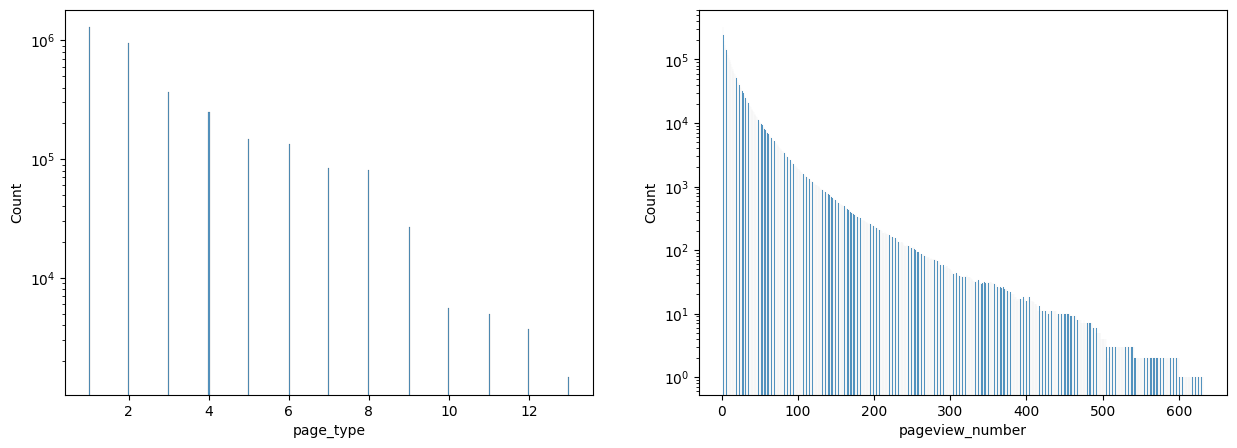

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
hist1 = sns.histplot(ax=axes[0], data=webstat, x="page_type")
hist1.set_yscale('log')
hist2 = sns.histplot(ax=axes[1], data=webstat, x="pageview_number")
hist2.set_yscale('log')
plt.show()

In [8]:
#webstat_agg = pd.read_parquet('./data/webstat_agg.parquet') # - долго считалось, так что сохранил результат

In [104]:
webstat_agg = webstat.groupby('sessionkey_id').agg(
    session_dur = ('date_time', lambda x: x.iloc[-1] - x.iloc[0]),
    pageview_total_duration = ('pageview_duration_sec', lambda x: np.nansum(x)),
    pageview_pos_mean = ('pageview_duration_sec', lambda x: np.nanmean(x[x > 0])),
    pageview_pos_std = ('pageview_duration_sec', lambda x: np.nanstd(x[x > 0])),
    pageview_neg_mean = ('pageview_duration_sec', lambda x: np.nanmean(x[x < 0])),
    pageview_neg_std = ('pageview_duration_sec', lambda x: np.nanstd(x[x < 0])),
    category_std = ('category_id', lambda x: np.nanstd(x)),
    is_in_sale = ('product_in_sale', lambda x: np.nanmean(x)),
    page_num = ('pageview_number', lambda x: x.shape[0]),
    ended_with_nan = ('pageview_duration_sec', lambda x: int(pd.isna(x.iloc[-1]))),
    first_page_type = ('page_type', lambda x: x.iloc[0]),
    last_page_type = ('page_type', lambda x: x.iloc[-1]),
    last_pageview_duration = ('pageview_duration_sec', lambda x: x.iloc[-1]),
    pagetype_1_num = ("page_type", lambda x: x[x==1].shape[0]),
    pagetype_2_num = ("page_type", lambda x: x[x==2].shape[0]),
    pagetype_3_num = ("page_type", lambda x: x[x==3].shape[0]),
    pagetype_4_num = ("page_type", lambda x: x[x==4].shape[0]),
    pagetype_5_num = ("page_type", lambda x: x[x==5].shape[0]),
    pagetype_6_num = ("page_type", lambda x: x[x==6].shape[0]),
    start_session = ('date_time', lambda x: x.iloc[0]),
    end_session = ('date_time', lambda x: x.iloc[-1])
)

webstat_agg = webstat_agg.fillna(0)

/tmp/ipykernel_156083/3487677951.py:4: RuntimeWarning: Mean of empty slice
  pageview_pos_mean = ('pageview_duration_sec', lambda x: np.nanmean(x[x > 0])),
/home/bogdan/.local/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_156083/3487677951.py:6: RuntimeWarning: Mean of empty slice
  pageview_neg_mean = ('pageview_duration_sec', lambda x: np.nanmean(x[x < 0])),
/tmp/ipykernel_156083/3487677951.py:9: RuntimeWarning: Mean of empty slice
  is_in_sale = ('product_in_sale', lambda x: np.nanmean(x)),


## LGBM

### Подготовил данные для LGBM

In [9]:
features = train.merge(webstat_agg, how='left', on='sessionkey_id')

In [10]:
features['have_session'] = ~features['start_session'].isna()
features['time_to_order'] = features['create_time'] - features['start_session']
features['after_order'] = features['end_session'] - features['create_time']

features.time_to_order = features.time_to_order.astype(int)
features.after_order = features.after_order.astype(int)
features.session_dur = features.session_dur.astype(int)

In [11]:
features.drop(columns_to_drop, inplace=True, axis=1)

In [12]:
features_test = test.merge(webstat_agg, how='left', on='sessionkey_id')

features_test['have_session'] = ~features_test['start_session'].isna()
features_test['time_to_order'] = features_test['create_time'] - features_test['start_session']
features_test['after_order'] = features_test['end_session'] - features_test['create_time']

features_test.time_to_order = features_test.time_to_order.astype(int)
features_test.after_order = features_test.after_order.astype(int)
features_test.session_dur = features_test.session_dur.astype(int)

features_test.drop(columns_to_drop, inplace=True, axis=1)

In [13]:
X, y = features.drop('is_callcenter', axis=1), features['is_callcenter']

In [14]:
train_size = int(0.46  * X.shape[0])
X_tr, X_val, y_tr, y_val = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

### Не тюнил параметры, брал дефолт из семинаров

In [72]:
lgb_tr = lgb.Dataset(X_tr, label=y_tr, free_raw_data=False)
lgb_val = lgb.Dataset(X_val, label=y_val, free_raw_data=False)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'eta': 0.1,
    'lambda': 1e-3,
    'early_stopping_round': 20,
    'seed': 911,
    'num_threads': 0,
    'verbosity': 1
}

model = lgb.train(
    params, lgb_tr, num_boost_round=200, # basic
    valid_names=['train', 'valid'], valid_sets=[lgb_tr, lgb_val],
)

[LightGBM] [Info] Number of positive: 17597, number of negative: 30516
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4495
[LightGBM] [Info] Number of data points in the train set: 48113, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.365743 -> initscore=-0.550523
[LightGBM] [Info] Start training from score -0.550523
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[115]	train's auc: 0.980263	valid's auc: 0.961656


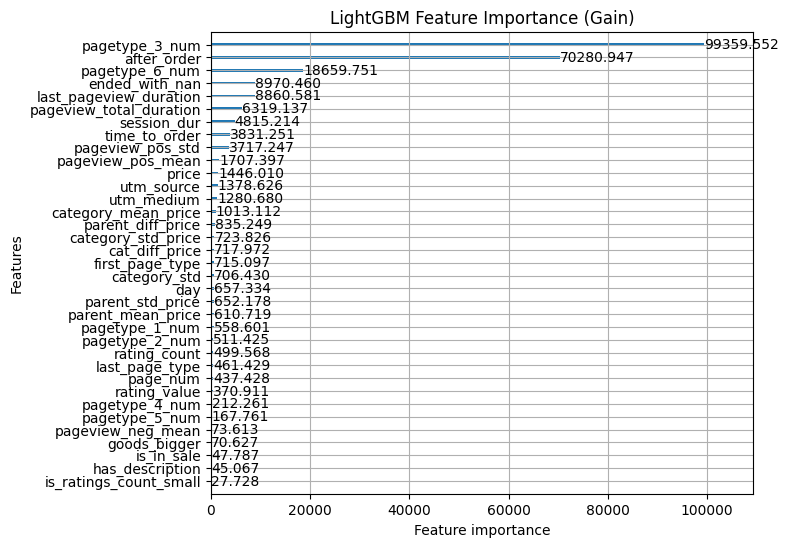

In [73]:
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

In [74]:
lgb_train = lgb.Dataset(X, label=y, free_raw_data=False)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'eta': 0.1,
    'lambda': 1e-3,

    'seed': 911,
    'num_threads': 0,
    'verbosity': 1
}

model = lgb.train(
    params, lgb_train, num_boost_round=115, # basic
)

[LightGBM] [Info] Number of positive: 37099, number of negative: 67496
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4748
[LightGBM] [Info] Number of data points in the train set: 104595, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354692 -> initscore=-0.598478
[LightGBM] [Info] Start training from score -0.598478


In [76]:
preds = model.predict(features_test)

In [77]:
submission = pd.DataFrame({'order_id': test['order_id'], 'is_callcenter': preds})

In [78]:
submission.to_csv('subm1.csv', index=False)

### Попытался обрезать ненужные фичи - скор не вырос

In [79]:
sorted_features = np.array(model.feature_name())[np.argsort(-model.feature_importance(importance_type='gain'))]

In [80]:
sorted_features, len(sorted_features)

(array(['pagetype_3_num', 'after_order', 'pagetype_6_num',
        'ended_with_nan', 'pageview_total_duration', 'session_dur',
        'pageview_pos_std', 'time_to_order', 'last_pageview_duration',
        'pageview_pos_mean', 'utm_medium', 'utm_source', 'price',
        'first_page_type', 'category_mean_price', 'parent_std_price',
        'last_page_type', 'day', 'category_std_price', 'parent_mean_price',
        'cat_diff_price', 'parent_diff_price', 'page_num', 'category_std',
        'pagetype_2_num', 'pagetype_1_num', 'rating_count',
        'pagetype_5_num', 'rating_value', 'pagetype_4_num', 'goods_bigger',
        'pageview_neg_mean', 'has_description', 'is_in_sale',
        'is_ratings_count_small', 'pageview_neg_std',
        'is_ratings_count_big', 'is_rating_big', 'have_session'],
       dtype='<U23'),
 39)

In [81]:
X, y = features.drop('is_callcenter', axis=1).drop(sorted_features[20:], axis=1), features['is_callcenter']

train_size = int(0.46  * X.shape[0])
X_tr, X_val, y_tr, y_val = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

lgb_tr = lgb.Dataset(X_tr, label=y_tr, free_raw_data=False)
lgb_val = lgb.Dataset(X_val, label=y_val, free_raw_data=False)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'eta': 0.1,
    'lambda': 1e-3,
    'early_stopping_round': 20,
    'seed': 911,
    'num_threads': 0,
    'verbosity': 1
}

model = lgb.train(
    params, lgb_tr, num_boost_round=200, # basic
    valid_names=['train', 'valid'], valid_sets=[lgb_tr, lgb_val],
)

[LightGBM] [Info] Number of positive: 6592, number of negative: 10604
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2875
[LightGBM] [Info] Number of data points in the train set: 17196, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383345 -> initscore=-0.475374
[LightGBM] [Info] Start training from score -0.475374
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	train's auc: 0.983804	valid's auc: 0.958925


In [83]:
lgb_train = lgb.Dataset(X, label=y, free_raw_data=False)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'eta': 0.1,
    'lambda': 1e-3,

    'seed': 911,
    'num_threads': 0,
    'verbosity': 1
}

model = lgb.train(
    params, lgb_train, num_boost_round=75, # basic
)

[LightGBM] [Info] Number of positive: 37099, number of negative: 67496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3261
[LightGBM] [Info] Number of data points in the train set: 104595, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354692 -> initscore=-0.598478
[LightGBM] [Info] Start training from score -0.598478


In [85]:
preds = model.predict(features_test.drop(sorted_features[20:], axis=1))
submission = pd.DataFrame({'order_id': test['order_id'], 'is_callcenter': preds})
submission.to_csv('subm2.csv', index=False)

## CatBoost

In [15]:
X, y = features.drop('is_callcenter', axis=1), features['is_callcenter']
X_tr, X_val, y_tr, y_val = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [16]:
device = 'GPU' if get_gpu_device_count() > 0 else 'CPU'
device

'GPU'

In [17]:
# cb_tr = cb.Pool(X_tr, y_tr)
# val_pool = cb.Pool(X_val, y_val)
# cb_tr.quantize()
params = {'objective': 'Logloss',
          'iterations':100,
          'learning_rate':0.1,
          'depth': 16,
          #'task_type': device,
          'eval_metric':'AUC',
          'use_best_model': False,
          'verbose': 5,
          'random_seed': 911
          #'silent': True
         }

model = cb.CatBoostClassifier(**params)

model.set_feature_names(X.columns.values)

# params = {'objective': 'Logloss', 'eta': 0.1, 'verbose': False, 'iterations': 50, 'thread_count': 16}

# model = cb.CatBoost(params)
# %time model.fit(cb_tr)
model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=10)

0:	test: 0.9435969	best: 0.9435969 (0)	total: 9.69s	remaining: 15m 58s
5:	test: 0.9505838	best: 0.9505838 (5)	total: 27.3s	remaining: 7m 8s
10:	test: 0.9505428	best: 0.9509529 (6)	total: 46.5s	remaining: 6m 16s
15:	test: 0.9509472	best: 0.9509529 (6)	total: 1m 6s	remaining: 5m 51s
20:	test: 0.9522771	best: 0.9522771 (20)	total: 1m 28s	remaining: 5m 32s
25:	test: 0.9523841	best: 0.9523841 (25)	total: 1m 48s	remaining: 5m 7s
30:	test: 0.9527904	best: 0.9527904 (30)	total: 2m 7s	remaining: 4m 42s
35:	test: 0.9530743	best: 0.9530743 (35)	total: 2m 25s	remaining: 4m 18s
40:	test: 0.9532720	best: 0.9533249 (38)	total: 2m 46s	remaining: 3m 59s
45:	test: 0.9529567	best: 0.9533249 (38)	total: 3m 7s	remaining: 3m 40s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9533249408
bestIteration = 38



In [18]:
params = {'objective': 'Logloss',
          'iterations':38,
          'learning_rate':0.1,
          'depth': 16,
          #'task_type': device,
          'eval_metric':'AUC',
          #'use_best_model': True,
          'verbose': 10,
          'random_seed': 911
          #'silent': True
         }

model = cb.CatBoostClassifier(**params)

model.set_feature_names(X.columns.values)
model.fit(X, y)

0:	total: 4.8s	remaining: 2m 57s
10:	total: 46.4s	remaining: 1m 53s
20:	total: 1m 28s	remaining: 1m 11s
30:	total: 2m 7s	remaining: 28.8s
37:	total: 2m 35s	remaining: 0us


In [19]:
preds = model.predict_proba(features_test)
submission = pd.DataFrame({'order_id': test['order_id'], 'is_callcenter': preds[:, 1]})
submission.to_csv('subm3.csv', index=False)

In [20]:
sorted_features = X.columns[np.argsort(-model.get_feature_importance())]

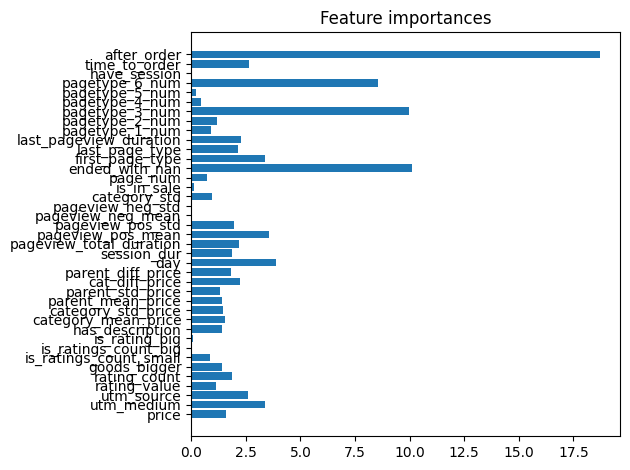

In [21]:
feature_importances = model.get_feature_importance()
plt.barh(X.columns, feature_importances)
plt.title('Feature importances')
plt.tight_layout()
plt.show()

## CatBoost top 20

In [22]:
X, y = features.drop('is_callcenter', axis=1).drop(sorted_features[20:], axis=1), features['is_callcenter']
X_tr, X_val, y_tr, y_val = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [23]:
params = {'objective': 'Logloss',
          'iterations':100,
          'learning_rate':0.1,
          'depth': 16,
          #'task_type': device,
          'eval_metric':'AUC',
          'use_best_model': False,
          'verbose': 5,
          'random_seed': 911
          #'silent': True
         }

model = cb.CatBoostClassifier(**params)

model.set_feature_names(X.columns.values)
model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=10)

0:	test: 0.9418493	best: 0.9418493 (0)	total: 2.93s	remaining: 4m 50s
5:	test: 0.9523658	best: 0.9523658 (5)	total: 19.1s	remaining: 4m 59s
10:	test: 0.9517793	best: 0.9523658 (5)	total: 41.1s	remaining: 5m 32s
15:	test: 0.9522729	best: 0.9523830 (13)	total: 1m 2s	remaining: 5m 27s
20:	test: 0.9530617	best: 0.9530617 (20)	total: 1m 16s	remaining: 4m 48s
25:	test: 0.9535252	best: 0.9535252 (25)	total: 1m 33s	remaining: 4m 25s
30:	test: 0.9537234	best: 0.9537234 (30)	total: 1m 48s	remaining: 4m
35:	test: 0.9540153	best: 0.9540313 (33)	total: 2m 2s	remaining: 3m 37s
40:	test: 0.9541429	best: 0.9542087 (38)	total: 2m 15s	remaining: 3m 15s
45:	test: 0.9538114	best: 0.9542087 (38)	total: 2m 29s	remaining: 2m 55s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.9542087056
bestIteration = 38



In [24]:
params = {'objective': 'Logloss',
          'iterations':38,
          'learning_rate':0.1,
          'depth': 16,
          #'task_type': device,
          'eval_metric':'AUC',
          #'use_best_model': True,
          'verbose': 10,
          'random_seed': 911
          #'silent': True
         }

model = cb.CatBoostClassifier(**params)

model.set_feature_names(X.columns.values)
model.fit(X, y)

0:	total: 3s	remaining: 1m 51s
10:	total: 29.8s	remaining: 1m 13s
20:	total: 57.9s	remaining: 46.9s
30:	total: 1m 25s	remaining: 19.3s
37:	total: 1m 45s	remaining: 0us


In [25]:
preds = model.predict_proba(features_test.drop(sorted_features[20:], axis=1))
submission = pd.DataFrame({'order_id': test['order_id'], 'is_callcenter': preds[:, 1]})
submission.to_csv('subm4.csv', index=False)

### UMAP

## 1. Понижение размерности (5 баллов) 

In [15]:
from sklearn.manifold import TSNE

In [37]:
tsne2D = TSNE(n_components=2, perplexity=5)
embeds = tsne2D.fit_transform(features.drop(['is_callcenter'], axis=1).dropna())
#features['cluster'] = embeds

In [38]:
tsne2D_df = pd.DataFrame(data = embeds, columns = ['x', 'y'])
tsne2D_df['cluster'] = features['is_callcenter']

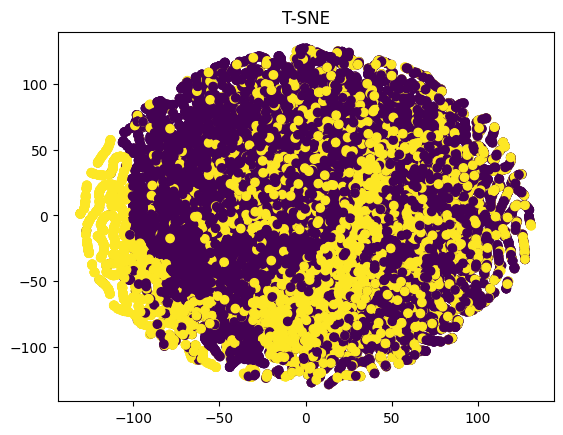

In [41]:
plt.scatter(x=embeds[:, 0], y=embeds[:, 1], c=features.dropna()['is_callcenter'])
plt.title("T-SNE")
plt.show()

Как видно, t-sne не дает адекватных результатов. Все классы смешались. Плюс он не умеет работать с нанами, которых у меня в данных много. UMAP же вообще работал миллион лет, и так и не посчитался.

## 2.Кластеризация (3 балла)

Так как методы понижения размерности не дали хорошего результата, решил использовать кластеризацию. В целом, если бы прошлый метод сработал - этот можно было бы не использовать, так как мы бы увидели хорошее разделение классов в латентном пространстве для

In [42]:
from sklearn.cluster import KMeans

In [53]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto")
embeds = kmeans.fit_transform(features.drop(['is_callcenter'], axis=1).dropna(axis=1))

### видим что два кластера - может шум, но решил попробовать.

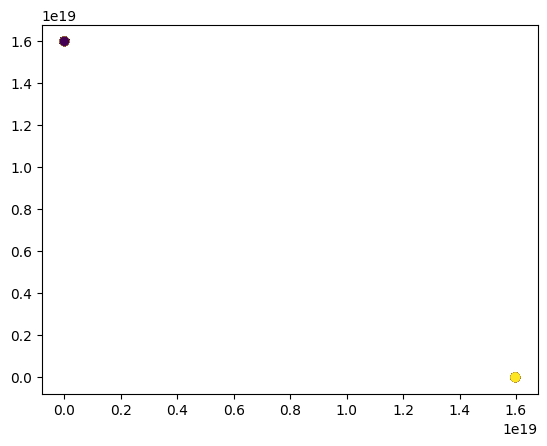

In [54]:
plt.scatter(x=embeds[:, 0], y=embeds[:, 1], c=features['is_callcenter'])
plt.show()

In [62]:
left_columns = features.drop(['is_callcenter'], axis=1).dropna(axis=1).columns
train_predict = kmeans.predict(features.drop(['is_callcenter'], axis=1)[left_columns])
test_predict = kmeans.predict(features_test[left_columns])

In [63]:
features['cluster'] = train_predict
features_test['cluster'] = test_predict

In [64]:
X, y = features.drop('is_callcenter', axis=1), features['is_callcenter']
train_size = int(0.46  * X.shape[0])
X_tr, X_val, y_tr, y_val = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

lgb_tr = lgb.Dataset(X_tr, label=y_tr, free_raw_data=False)
lgb_val = lgb.Dataset(X_val, label=y_val, free_raw_data=False)

params = {
    'objective': 'binary',
    'metric': 'auc',
    'eta': 0.1,
    'early_stopping_round': 20,
    'seed': 911,
    'num_threads': 0,
    'verbosity': 1
}

model = lgb.train(
    params, lgb_tr, num_boost_round=200, # basic
    valid_names=['train', 'valid'], valid_sets=[lgb_tr, lgb_val],
)

[LightGBM] [Info] Number of positive: 17597, number of negative: 30516
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4497
[LightGBM] [Info] Number of data points in the train set: 48113, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.365743 -> initscore=-0.550523
[LightGBM] [Info] Start training from score -0.550523
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[83]	train's auc: 0.976171	valid's auc: 0.961444


In [67]:
lgb_train = lgb.Dataset(X, label=y, free_raw_data=False)
params = {
    'objective': 'binary',
    'metric': 'auc',
    'eta': 0.1,
    'lambda': 1e-3,

    'seed': 911,
    'num_threads': 0,
    'verbosity': 1
}

model = lgb.train(
    params, lgb_train, num_boost_round=85, # basic
)

[LightGBM] [Info] Number of positive: 37099, number of negative: 67496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4750
[LightGBM] [Info] Number of data points in the train set: 104595, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354692 -> initscore=-0.598478
[LightGBM] [Info] Start training from score -0.598478


In [68]:
preds = model.predict(features_test)
submission = pd.DataFrame({'order_id': test['order_id'], 'is_callcenter': preds})
submission.to_csv('subm5.csv', index=False)

### Результатов это не дало(